## モデルの学習を行うプログラム

In [ ]:
#Googleドライブにアクセスできるようにする
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
% cd /content/drive/MyDrive/UmaMusume_detection

/content/drive/MyDrive/UmaMusume_detection


In [ ]:
#必要なライブラリの読み込み
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset

#訓練用の画像とテスト用の画像が格納されているディレクトリのパス
train_path = "train_data_augment/"
test_path = "test_data/"

#Transformを作成する。
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#ImageFolderのインスタンス生成
train_set = ImageFolder(root=train_path, # 画像が保存されているフォルダのパス
                       transform=transform) # Tensorへの変換

test_set = ImageFolder(root=test_path, # 画像が保存されているフォルダのパス
                       transform=transform) # Tensorへの変換

print(train_set.class_to_idx)
print(test_set.class_to_idx)

#DataLoaderを作成する。
train_loader = DataLoader(train_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

{'elcondorpasa': 0, 'grasswonder': 1, 'kinghalo': 2, 'seiunsky': 3, 'specialweek': 4}
{'elcondorpasa': 0, 'grasswonder': 1, 'kinghalo': 2, 'seiunsky': 3, 'specialweek': 4}


In [ ]:
#必要なライブラリの読み込み
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torchsummary import summary
import numpy as np

#モデルの定義
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.cn1 = nn.Conv2d(3, 6, 5)
    self.pool1 = nn.MaxPool2d(2, 2)
    self.cn2 = nn.Conv2d(6, 16, 5)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cn3 = nn.Conv2d(16, 32, 4)
    self.dropout = nn.Dropout2d()
    self.fc1 = nn.Linear(32*10*10, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 5)
  
  def forward(self, x):
    x = F.relu(self.cn1(x))
    x = self.pool1(x)
    x = F.relu(self.cn2(x))
    x = self.pool2(x)
    x = F.relu(self.cn3(x))
    x = self.dropout(x)
    x = x.view(-1, 32*10*10)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
        
    return x

In [ ]:
#1エポックの学習を行う関数
def train_epoch(model, optimizer, criterion, train_loader, epoch):

  train_loss = 0
  model.train()

  for i, (images, labels) in enumerate(train_loader):
    images, labels = images, labels
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  
  #train lossを計算
  train_loss = train_loss / len(train_loader.dataset)

  #学習済みのモデルを保存
  outfile = "cnn-" + str(epoch) + ".model"
  torch.save(model.state_dict(), outfile) 
  print(outfile," saved")
  
  return train_loss

In [ ]:
#推論を行うための関数
def inference(model, optimizer, criterion, test_loader):

  model.eval()
  test_loss=0
  correct=0

  with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
      images, labels = images, labels
      outputs = model(images)
      loss = criterion(outputs, labels)
      test_loss += loss.item()
      pred = outputs.argmax(dim=1, keepdim=True)
      correct += pred.eq(labels.view_as(pred)).sum().item()

    #test lossを計算
    test_loss = test_loss / len(test_loader.dataset)
    #Accuracyを計算
    accuracy = correct / len(test_loader.dataset)
    
  return test_loss, accuracy

In [ ]:
#学習と推論を行うための関数
def run(num_epochs, model, optimizer, criterion, train_loader, test_loader):

  train_loss_list = [] #各エポックごとのtrain lossを格納するリスト
  test_loss_list = [] #各エポックごとのtest lossを格納するリスト
  accuracy_list = [] #各エポックごとのAccuracyを格納するリスト
  epoch_list = [] #エポック数を格納するリスト

  #学習と推論を行う関数を呼び出す
  for epoch in range(num_epochs):
    train_loss = train_epoch(model, optimizer, criterion, train_loader, epoch)
    test_loss, accuracy = inference(model, optimizer, criterion, test_loader)

    print(f'Epoch [{epoch+1}], train_Loss : {train_loss:.4f}, test_Loss : {test_loss:.4f}, Accuracy : {accuracy:4f}')

    #それぞれのリストに実行結果を格納
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    accuracy_list.append(accuracy)
    epoch_list.append(epoch+1)
  
  return train_loss_list, test_loss_list, accuracy_list, epoch_list

In [ ]:
#モデルの定義
model = CNN()
#最適化手法を設定
optimizer = optim.Adam(model.parameters(), lr=1e-5)
#損失関数の設定
criterion = nn.CrossEntropyLoss()

#モデルの学習と推論を開始
train_loss_list, test_loss_list, accuracy_list, epoch_list = run(100, model, optimizer, criterion, train_loader, test_loader)

cnn-0.model  saved
Epoch [1], train_Loss : 0.0254, test_Loss : 0.0280, Accuracy : 0.190476
cnn-1.model  saved
Epoch [2], train_Loss : 0.0253, test_Loss : 0.0280, Accuracy : 0.190476
cnn-2.model  saved
Epoch [3], train_Loss : 0.0252, test_Loss : 0.0279, Accuracy : 0.190476
cnn-3.model  saved
Epoch [4], train_Loss : 0.0252, test_Loss : 0.0279, Accuracy : 0.190476
cnn-4.model  saved
Epoch [5], train_Loss : 0.0251, test_Loss : 0.0278, Accuracy : 0.212121
cnn-5.model  saved
Epoch [6], train_Loss : 0.0250, test_Loss : 0.0276, Accuracy : 0.354978
cnn-6.model  saved
Epoch [7], train_Loss : 0.0248, test_Loss : 0.0273, Accuracy : 0.419913
cnn-7.model  saved
Epoch [8], train_Loss : 0.0244, test_Loss : 0.0269, Accuracy : 0.424242
cnn-8.model  saved
Epoch [9], train_Loss : 0.0239, test_Loss : 0.0263, Accuracy : 0.424242
cnn-9.model  saved
Epoch [10], train_Loss : 0.0233, test_Loss : 0.0256, Accuracy : 0.411255
cnn-10.model  saved
Epoch [11], train_Loss : 0.0225, test_Loss : 0.0249, Accuracy : 0.411

In [ ]:
#実行ログを出力
f = open("cnn_log.txt", "w")
for i in range(100):
  f.write("Epoch [{}] : train_loss {:.4f}, test_loss {:.4f}, Accuracy {:.4f}\n".format(epoch_list[i], train_loss_list[i], test_loss_list[i], accuracy_list[i]))
f.close()

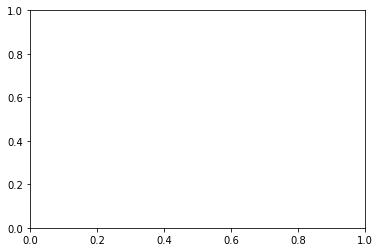

In [ ]:
#必要なライブラリの読み込み
import matplotlib.pyplot as plt

#train lossの変化をグラフで表示
plt.plot(epoch_list, train_loss_list, label='train_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend(loc='upper right')
plt.savefig("train_loss.png")
plt.gca().clear()

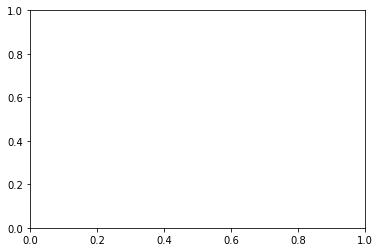

In [ ]:
#test lossの変化をグラフで表示
plt.plot(epoch_list, test_loss_list, label='test_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend(loc='upper right')
plt.savefig("test_loss.png")
plt.gca().clear()

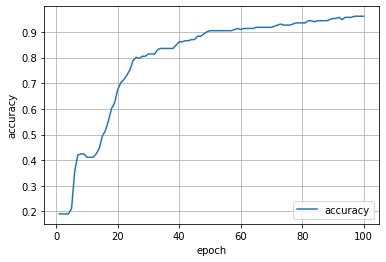

In [ ]:
#Accuracyの変化をグラフで表示
plt.plot(epoch_list, accuracy_list, label='accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.savefig("accuracy.png")

In [ ]:
#モデルの構造を表示
model = CNN()
model.load_state_dict(torch.load("cnn-99.model"))
model.cuda()
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 60, 60]             456
         MaxPool2d-2            [-1, 6, 30, 30]               0
            Conv2d-3           [-1, 16, 26, 26]           2,416
         MaxPool2d-4           [-1, 16, 13, 13]               0
            Conv2d-5           [-1, 32, 10, 10]           8,224
         Dropout2d-6           [-1, 32, 10, 10]               0
            Linear-7                  [-1, 120]         384,120
            Linear-8                   [-1, 84]          10,164
            Linear-9                    [-1, 5]             425
Total params: 405,805
Trainable params: 405,805
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.36
Params size (MB): 1.55
Estimated Total Size (MB): 1.95
-------------------------------------------